# Preprocessing Visum dataset

We have to goals:
1. prepare the image and mask for processing
2. estimate the value of the hyper-parameters which will be used for training

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import torch
import numpy as np
import collections
from MODULES.preprocessing import *
from MODULES.namedtuple import ImageBbox, PreProcess

### Helper functions

In [3]:
PREPROCESS = collections.namedtuple("PREPROCESS","img roi_mask bbox_original bbox_crop")

def plot_img_and_histo(img, img_GRAY, histo_mask, figsize=(24, 12)):
    
    figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 12))
    _ = axes[0,0].imshow(img)
    _ = axes[0,1].hist(img[histo_mask], density=True, bins=100)
    _ = axes[1,0].imshow(img_GRAY, cmap='gray')
    _ = axes[1,1].hist(img_GRAY[histo_mask], density=True, bins=100)
    _ = axes[0,0].set_title("rescaled image")
    _ = axes[0,1].set_title("rescaled histogram")
    _ = axes[1,0].set_title("rescaled image GRAY")
    _ = axes[1,1].set_title("rescaled histogram GRAY")

def plot_img_and_nuclei(img_gray, NUCLEI_mask, window, figsize=(24, 12)):

    w0,h0,w1,h1 = window 
    figure, axes = plt.subplots(ncols=3, nrows=2, figsize=figsize)
    gray_img = axes[0,0]
    instances = axes[0,1]
    overlay = axes[0,2]

    gray_img_zoom = axes[1,0]
    instances_zoom = axes[1,1]
    overlay_zoom = axes[1,2]

    gray_img.imshow(img_gray, cmap='gray')
    instances.imshow(NUCLEI_mask, cmap='gray')
    overlay.imshow(img_gray)
    overlay.imshow(NUCLEI_mask, alpha=0.5, cmap='gray')

    gray_img_zoom.imshow(img_gray[w0:w1,h0:h1], cmap='gray')
    instances_zoom.imshow(NUCLEI_mask[w0:w1,h0:h1], cmap='gray')
    overlay_zoom.imshow(img_gray[w0:w1,h0:h1])
    overlay_zoom.imshow(NUCLEI_mask[w0:w1,h0:h1], alpha=0.5)#, cmap='gray')

    _ = gray_img.set_title("RAW GRAYSCALE image")
    _ = gray_img_zoom.set_title("RAW GRAYSCALE image, zoom")
    _ = instances.set_title("NUCLEI only")
    _ = instances_zoom.set_title("NUCLEI only, zoom")
    _ = overlay.set_title("overlay image and nuclei")
    _ = overlay_zoom.set_title("overlay image and nuclei, zoom")
    
    
def show_video(frames: np.ndarray,
               ref_image: np.ndarray,
               sigma: np.ndarray,
               figsize: tuple = (8, 4),
               interval: int = 50):
    """
    :param video: an ndarray with shape (n_frames, height, width, 3)
    """
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    ax_image = axs[0]
    ax_video = axs[1]
    
    # image
    ax_image.axis('off')
    ax_image.imshow(ref_image)
    ax_image.set_title("ref image")
    
    ax_video.axis('off')
    ax_video.imshow(frames[0, ...])
    ax_video.set_title("title")
        
    plt.tight_layout()
    plt.close()
    
    def init():
        ax_video.imshow(frames[0, ...])
        ax_video.set_title("title")
        
    def animate(i):
        title = 'corrupted prediction, frame={0:3d}, sigma={1:.3f}'.format(i,sigma[i])
        ax_video.imshow(frames[i, ...])
        ax_video.set_title(title)
        
    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=frames.shape[0],
        interval=interval)
    
    return HTML(anim.to_html5_video())

## Use coarse resolution image to estimate the parameters

Define the parameters specific to this dataset

In [4]:
file_1 = "191203_5k_CN021_2_Allen_HE_AM_SNA-Spot000001.jpg"
file_2 = "191206_5K_CN026_1_allen_HE_SN_AM-Spot000001.jpg"
file_3 = "200128_Allen_V19T26_ID098_AM-Spot000001.jpg"
file_4 = "200128_Allen_V4_V19T26_ID098_A-Spot000001.jpg"

file = file_2
mode = "RGB"  # options are: I, RGB, L, F
reduction_factor=10
outside_ROI = "mean" # options are: mean, zero
remove_bg = False  # options are: True, False
q = (0.01, 99.99)
gamma = 1.0 

import skimage.filters
import skimage.morphology
import skimage.color
import scipy

def find_ROI_mask(img_GRAY):
    """ Find the region of interest by thresholding """
    thresh = skimage.filters.threshold_otsu(img_GRAY)
    return getLargestCC(scipy.ndimage.binary_fill_holes(img_GRAY < thresh))

def find_NUCLEI_mask(img_GRAY, ROI_mask):
    """ Find the nuclei by doing another thresholding inside the ROI """
    thresh = skimage.filters.threshold_local(new_small_GRAY, 
                                             block_size=25, 
                                             method='mean', 
                                             offset=0, 
                                             mode='constant', 
                                             cval=0)
    return (img_GRAY < thresh - 0.1) * ROI_mask

### 1. Obtain a coarse version of the image 

small_img.flags ->   C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

shape, dtype --> (3174, 3174, 3) uint8
shape, dtype --> (3174, 3174) float64


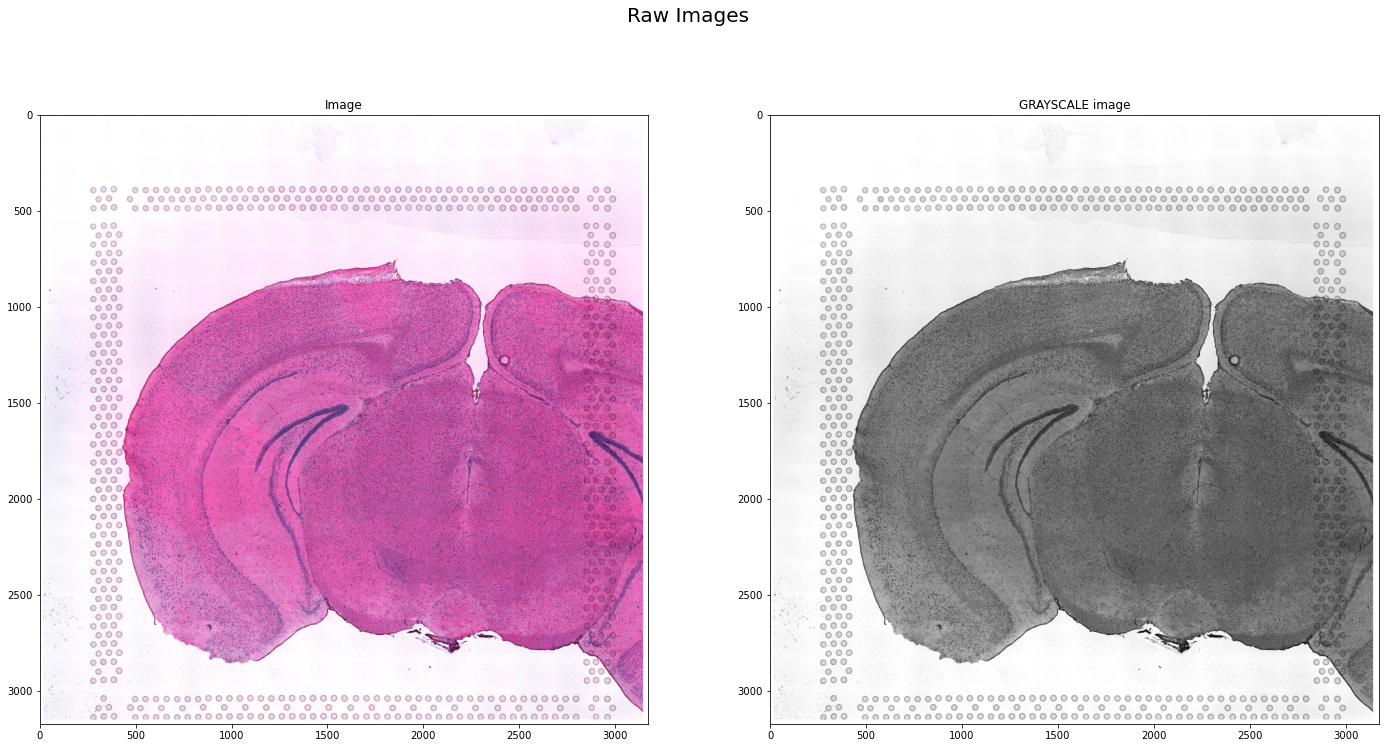

In [5]:
small_img = pil_to_numpy(file, 
                         mode=mode, 
                         reduction_factor=reduction_factor)

print("small_img.flags ->", small_img.flags)

if len(small_img.shape) == 3:
    small_img_GRAY = skimage.color.rgb2gray(small_img)
elif len(small_img.shape) == 2:
    small_img_GRAY = skimage.img_as_float(small_img)
else:
    raise Exception("You should never be here")

print("shape, dtype -->",small_img.shape, small_img.dtype)
print("shape, dtype -->",small_img_GRAY.shape, small_img_GRAY.dtype)

figure, axes = plt.subplots(ncols=2, figsize=(24, 12))
figure.suptitle("Raw Images", fontsize=20)
_ = axes[0].imshow(small_img)
_ = axes[1].imshow(small_img_GRAY, cmap='gray')
_ = axes[0].set_title("Image")
_ = axes[1].set_title("GRAYSCALE image")

### 2. Find the ROI_mask by thresholding

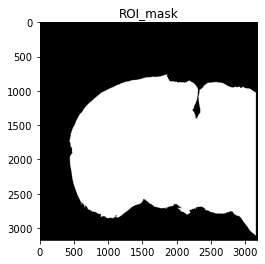

In [6]:
small_ROI_mask = find_ROI_mask(small_img_GRAY)

plt.imshow(small_ROI_mask, cmap='gray')
_ = plt.title("ROI_mask")

### 3. Set the region outside ROI to either ZERO or MEAN

In [7]:
if outside_ROI == "zero":
    GRAY_channel_inside_ROI = 0 
    channel_inside_ROI = 0 
elif outside_ROI == "mean":
    GRAY_channel_inside_ROI = np.mean(small_img_GRAY[small_ROI_mask]).astype(small_img_GRAY.dtype)
    channel_inside_ROI = np.mean(small_img[small_ROI_mask], axis=0).astype(small_img.dtype)
    
print("GRAY_channel_inside_ROI",GRAY_channel_inside_ROI)
print("channel_inside_ROI",channel_inside_ROI)

new_small_GRAY = np.copy(small_img_GRAY)
new_small = np.copy(small_img)
new_small_GRAY[~small_ROI_mask] = GRAY_channel_inside_ROI
new_small[~small_ROI_mask] = channel_inside_ROI

GRAY_channel_inside_ROI 0.47175606439783113
channel_inside_ROI [199  92 167]


### 4. Find the nuclei
by performing an additional thresholdoing inside the ROI.

In [8]:
small_NUCLEI_mask = find_NUCLEI_mask(small_img_GRAY, small_ROI_mask)

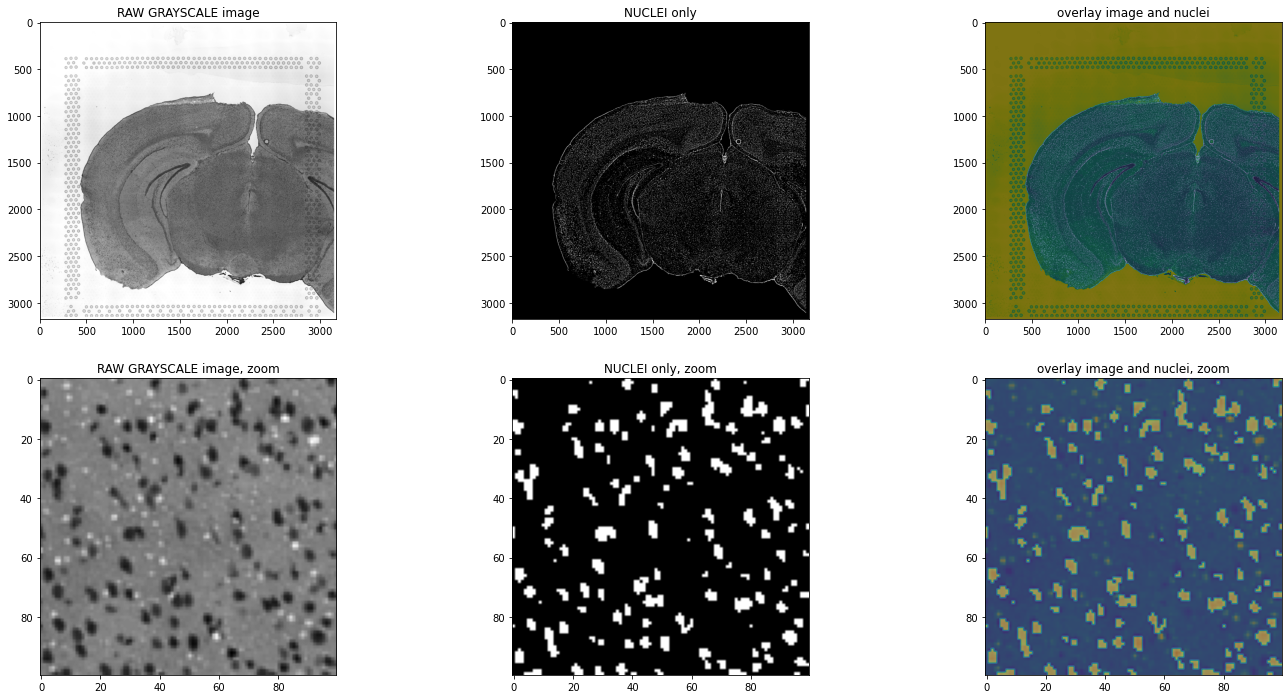

In [9]:
delta = 100
iw, ih = 1000, 1000
plot_img_and_nuclei(img_gray=small_img_GRAY, 
                    NUCLEI_mask=small_NUCLEI_mask, 
                    window = [iw,ih,iw+delta,ih+delta], 
                    figsize=(24, 12))

In [10]:
print("np.sum(small_NUCLEI_mask) ------>",np.sum(small_NUCLEI_mask))
print("np.sum(small_ROI_mask) ->",np.sum(small_ROI_mask))
print("Estimated fraction cell_pixel -->",float(np.sum(small_NUCLEI_mask))/np.sum(small_ROI_mask))

np.sum(small_NUCLEI_mask) ------> 480345
np.sum(small_ROI_mask) -> 4807362
Estimated fraction cell_pixel --> 0.09991862480919889


### 5. Rempove the background if necessary

In [11]:
if remove_bg:
    new_small[~small_NUCLEI_mask] = 0
    new_small_GRAY[~small_NUCLEI_mask] = 0
    histo_mask = small_NUCLEI_mask
else:
    histo_mask = small_ROI_mask

### 6. Rescale the images appropriately and show the histogram.
Any global transformation is acceptable (i.e. historgram equalization, adjust_gamma etc). The importat thing is that the transformation can be expressed as a rule:

$\text{old_integer_value} \to \text{new_integer_value}$

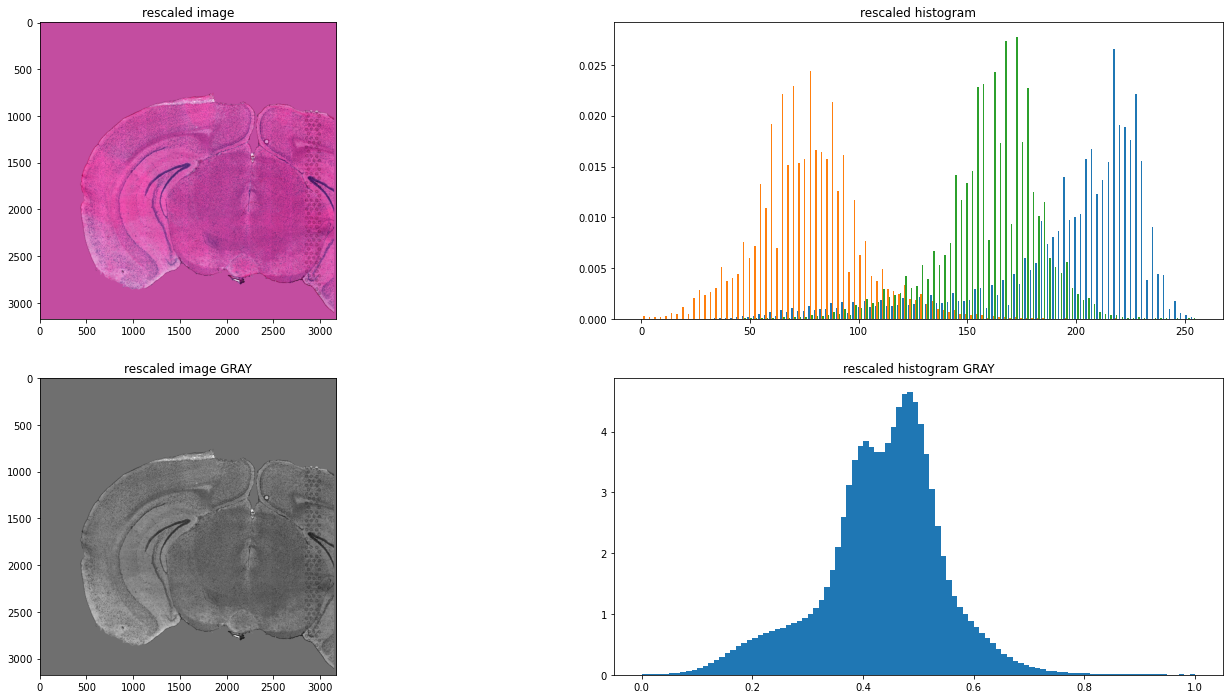

In [12]:
new_small, transform_pixel = rescale_intensity(new_small, histo_mask, q=q, gamma=gamma)
new_small_GRAY, transform_pixel_GRAY = rescale_intensity(new_small_GRAY, histo_mask, q=q, gamma=gamma)

plot_img_and_histo(img=new_small, 
                   img_GRAY=new_small_GRAY, 
                   histo_mask=histo_mask, 
                   figsize=(24, 12))

# Now I can estimate parameters

### 1. Chose sigma for mean square error

Deteriorate the image by applying gaussian filter with increasing spatial support. Note that after the gaussian filters the image is converted to float in range (0,1)

In [13]:
gaussian_filter = np.arange(0,10)  # sigma=0 has no smoothing, i.e. original image
predictions = np.zeros([gaussian_filter.shape[0]]+list(new_small.shape))
multichannel = (len(new_small.shape)==3)
for n,s in enumerate(gaussian_filter):
    predictions[n] = skimage.filters.gaussian(new_small, sigma=s, multichannel=multichannel)

print(predictions.shape, predictions.dtype, np.min(predictions[0]),np.max(predictions[0]))

(10, 3174, 3174, 3) float64 0.0 1.0


Now I compute MSE of these deteriorated images.
The idea is to find a deteriorated image which is looking acceptable and fix sigma to that value.
Note that only values inside ROI are considered.


Demanding $ MSE = \frac{1}{W H C}\sum_{x,y,c} \left( \frac{\text{prediction} - \text{reference}}{\sigma}\right)^2 = 1$ 
implies that
$\sigma = \sqrt{ \frac{1}{W H C} \sum_{x,y,c} \left(\text{prediction} - \text{reference}\right)^2} $

In [14]:
sigma = compute_sqrt_mse(predictions, roi_mask=small_ROI_mask)

In [15]:
delta = 200
iw, ih = 1000, 1000
print(iw,ih,delta)

show_video(frames=predictions[:,iw:iw+delta,ih:ih+delta], 
           ref_image=new_small[iw:iw+delta,ih:ih+delta],
           sigma=sigma,
           interval=500)

1000 1000 200


# Repeat pipeline for high resolution images
Apply the transformations determined using the small resolution images

1. Open the image in native resolution. 
2. Upsample small_ROI_mask to large_ROI_mask
3. Set region outside ROI to either zero or mean
4. Upsample the small_NUCLEI_mask to large_NUCLEI mask
5. If necessary set the BG to zero
6. Rescale the pixel intensities

In [16]:
large_img = pil_to_numpy(file, mode=mode, reduction_factor=1)
large_ROI_mask = skimage.transform.resize(small_ROI_mask, 
                                          output_shape=large_img.shape[0:2], 
                                          order=0).astype(bool)
large_NUCLEI_mask = skimage.transform.resize(small_NUCLEI_mask, 
                                             output_shape=large_img.shape[0:2], 
                                             order=0).astype(bool)
large_img[~large_ROI_mask] = channel_inside_ROI
if remove_bg:
    large_img[~large_NUCLEI_mask] = 0

In [17]:
# Crop
bbox_original= BBOX(min_row=0,
                    min_col=0,
                    max_row=large_ROI_mask.shape[0],
                    max_col=large_ROI_mask.shape[1])
bbox_crop = find_bbox(large_ROI_mask)

print(bbox_original)
print(bbox_crop)

cropped_img = large_img[bbox_crop.min_row:bbox_crop.max_row,
                        bbox_crop.min_col:bbox_crop.max_col]
cropped_ROI_mask = large_ROI_mask[bbox_crop.min_row:bbox_crop.max_row,
                                  bbox_crop.min_col:bbox_crop.max_col]

BBOX(min_row=0, min_col=0, max_row=31744, max_col=31744)
BBOX(min_row=7571, min_col=4281, max_row=31114, max_col=31434)


In [18]:
# Rescale pixel intensity
rescaled_cropped_large = transform_pixel(cropped_img)

### Visualize few examples

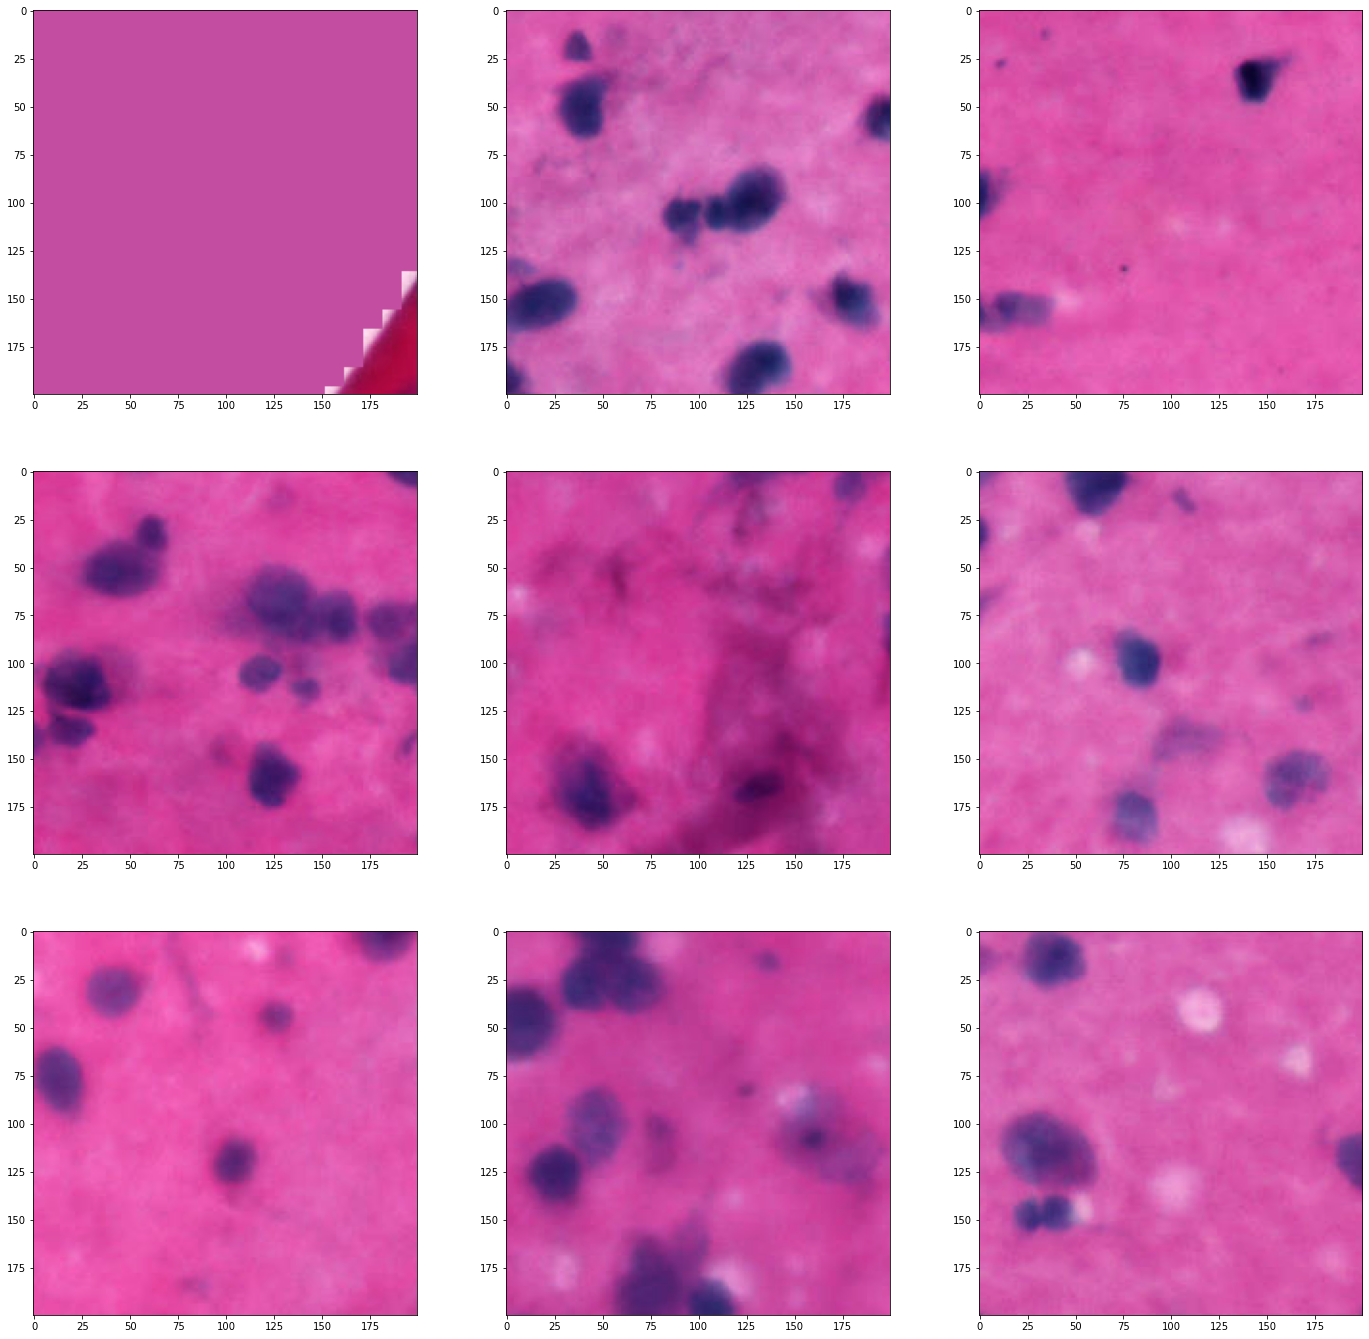

In [19]:
N_examples = 9
ncols=3
nrows=int(np.ceil(N_examples/ncols))
delta = 200
iw_array = np.random.randint(low=0, high=cropped_ROI_mask.shape[-2]-delta, size=N_examples, dtype=int)
ih_array = np.random.randint(low=0, high=cropped_ROI_mask.shape[-1]-delta, size=N_examples, dtype=int)
#print(iw,ih)

figure, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(24, 24))
for n in range(N_examples):
    r = int(n / ncols)
    c = np.mod(n,ncols)
    axes[r,c].imshow(rescaled_cropped_large[iw_array[n]:iw_array[n]+delta,
                                            ih_array[n]:ih_array[n]+delta], cmap='gray')

From these images I see that cells have a typical size of 25.
To be safe I set the cell size in the range 15-45.
We also see that in a window of size 200x200 there are no more than 30 nuclei

In [20]:
import torchvision.transforms as transforms

f = "preprocessed_"+file
tmp=PreProcess(img=transforms.ToTensor()(rescaled_cropped_large),
               roi_mask=transforms.ToTensor()(cropped_ROI_mask),
               bbox_original=bbox_original,
               bbox_crop=bbox_crop)
torch.save(tmp, f)

# Conclusion 

We have:
1. generated a cropped version of the image and the mask
2. figured out that the fraction of pixel belonging to the nuclei is about 15
3. a reasonable value for sigma to use in the MSE is 0.05
4. the nuclei have a linear size in the range 15-45 pixels
5. in a window of 200x200 pixel we expect no more that 30 nuclei